In [1]:
import torch
import lightning as L

from phase_space_reconstruction.diagnostics import ImageDiagnostic

from phase_space_reconstruction.modeling import GPSR, GPSRQuadScanLattice
from phase_space_reconstruction.train import LitGPSR
from phase_space_reconstruction.beams import NNParticleBeamGenerator
from phase_space_reconstruction.datasets import FourDReconstructionDataset

In [2]:
# create diagnostic screen:
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

# get model
p0c = 43.36e6 # reference momentum in eV/c

gpsr_lattice = GPSRQuadScanLattice(
    l_quad=0.1, l_drift=1.0, diagnostic=screen
)

# get training dataset
train_dset = torch.load("example_data/example_datasets/reconstruction_4D_train.dset")

In [3]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger('.', )
trainer = L.Trainer(limit_train_batches=100,max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params
------------------------------------
0 | gpsr_model | GPSR | 1.1 K 
------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interva

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [4]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

## Evaluate model on test samples to compare predictions

In [5]:
test_dset = torch.load("example_data/example_datasets/reconstruction_4D_test.dset")
test_pred = gpsr_model(test_dset.parameters)[0].detach()
test_pred_dset = FourDReconstructionDataset(test_dset.parameters, test_pred, bins)

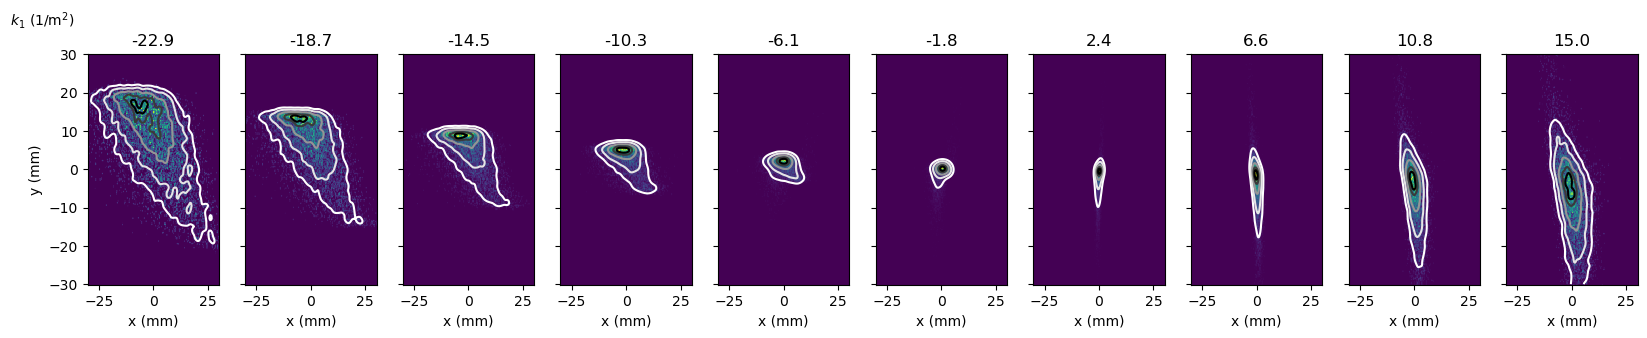

In [6]:
fig, ax = test_dset.plot_data(overlay_data=test_pred_dset)
fig.set_size_inches(20,3)

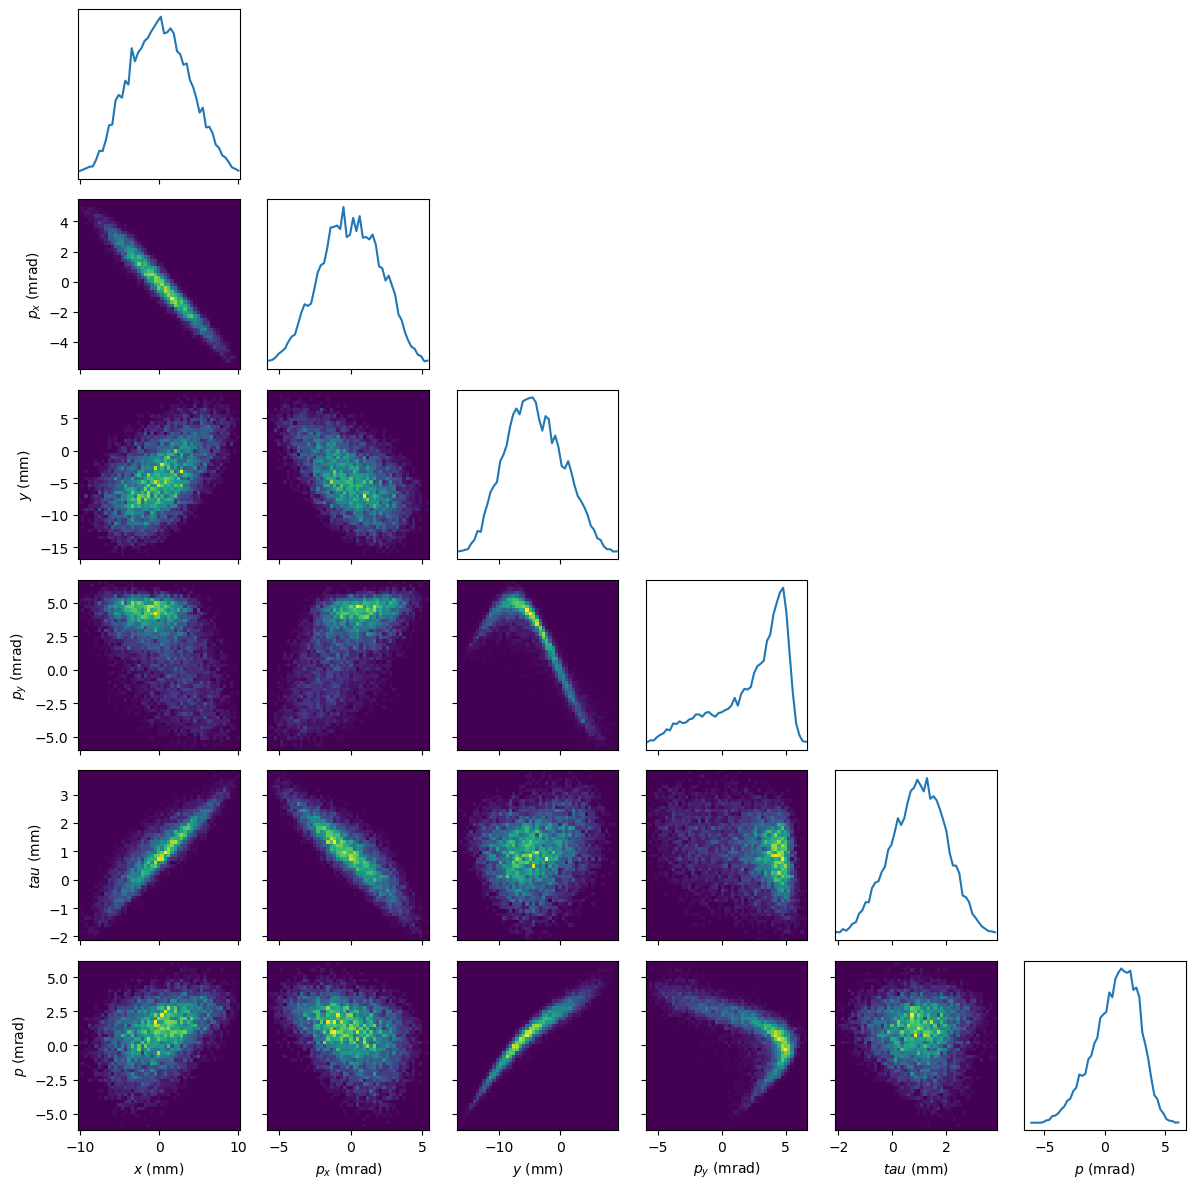

In [8]:
reconstructed_beam.plot_distribution();